 <h1 style="text-align: center; font-size: 50px;font-weight: bold;"> Bayesian Machine Learning
   </h1>


 <h1 style="text-align: center; font-size: 25px;font-weight: bold;"> Project : Computing Nonvacuous Generalization Bounds for Deep (Stochastic) Neural
 Networks with Many More Parameters than Training Data </h1>


In [577]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.init as init
import numpy as np



In [578]:
transform = transforms.ToTensor()

# Download and load the dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [579]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [580]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# Get a batch of images and labels
images, labels = next(iter(train_loader))

In [581]:
print(images.shape, labels.shape)


torch.Size([100, 1, 28, 28]) torch.Size([100])


tensor(0.1409) tensor(1.) tensor(0.)


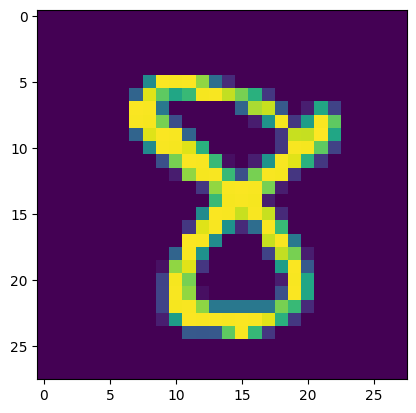

In [582]:
plt.imshow(images[0,0,:,:])
print(torch.mean(images[0,0,:,:]), torch.max(images[0,0,:,:]), torch.min(images[0,0,:,:]))

In [583]:
class MLP(nn.Module):
    def __init__(self, nb_nodes, nb_hidden_layers, classes=1):
        super().__init__()
        
        layers = [nn.Linear(28*28, nb_nodes), nn.ReLU()]
        
        for _ in range(nb_hidden_layers):
            layers.append(nn.Linear(nb_nodes, nb_nodes))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=0.4))
        
        layers.append(nn.Linear(nb_nodes, classes))
        self.layers = nn.Sequential(*layers)

        self.initialize_weights()  # Initialize weights after layer creation

    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.layers(x)
        return x

    def truncated_normal_(self, tensor, mean=0, std=0.04, low=-2, high=2):
        """Truncated normal initialization for weights."""
        with torch.no_grad():
            tensor.normal_(mean, std)
            tensor.clamp_(low*std, high*std)  # Truncate values to [-2*sigma, 2*sigma]

    def initialize_weights(self):
        """Initialize weights and biases as per the given specifications."""
        linear_layer = 0
        for  m in self.modules():
            if isinstance(m, nn.Linear):
                self.truncated_normal_(m.weight, mean=0, std=0.04, low=-2, high=2)
                
                if linear_layer == 0:  # First layer after input
                    init.constant_(m.bias, 0.1)
                else:
                    init.constant_(m.bias, 0)
                linear_layer +=1

In [584]:
lr = 0.0001
epochs = 200
patience = 20

In [585]:
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = MLP(nb_nodes=600, nb_hidden_layers=2).to(device)
model = MLP(nb_nodes=600, nb_hidden_layers=2)
print(model)

# optimizer = torch.optim.RMSprop(model.parameters(), lr = lr, momentum=0.9, eps=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=600, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=600, out_features=600, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=600, out_features=1, bias=True)
  )
)


In [586]:
def print_weights_and_biases(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"Layer: {name} | Weights:\n{param.data}\n")
        elif "bias" in name:
            print(f"Layer: {name} | Biases:\n{param.data}\n")

# print_weights_and_biases(model)


In [587]:
def plot_training_history(history_train_loss, history_val_loss):
    epochs = range(1, len(history_train_loss) + 1)

    # figure avec deux sous-graphes côte à côte
    plt.figure(figsize=(14, 5))

    # Graphique pour la perte
    plt.semilogy(epochs, history_train_loss, label='Train Loss', marker='o')
    plt.semilogy(epochs, history_val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def label_modif(label):
    """ Changes the labels of the MNIST dataset to transform it into a binary
    classification problem by mapping numbers {0,.....,4} to label 1 and {5,......,9} to label -1"""
    # print("label check before", label)
    label[label<=4] = 1
    label[label >=5] = -1
    # print("label check after", label)
    
    return label
def logistic_loss(labels, outputs):
    loss = (1/(np.log(2)))*torch.log(1+torch.exp(-labels*outputs))
    return torch.mean(loss)
def training_pipeline(epochs, model, train_loader, test_loader, optimizer, patience):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_train_tab = []
    loss_valid_tab = []
    best_val_loss = float("inf")
    best_model = None
    model.to(device)
    print("Module sélectionné pour l'entraînement : ", device)
    epochs_no_improve = 0
    for epoch in range(epochs):
        model.train()
        compteur_train = 0
        compteur_test = 0
        loss_train = 0
        loss_test = 0
        for k, (image_train, label_train) in enumerate(train_loader):
            # print("TRAIN")
            label_train = label_modif(label_train)

            image_train, label_train = image_train.to(device), label_train.to(device)
            # print("max, min", torch.min(image_train).item, torch.max(image_train))
            optimizer.zero_grad()
            output = model(image_train)
            # print("output", torch.mean(output).item())
            loss = logistic_loss(label_train, output.squeeze(1))
            loss_train+=loss
            compteur_train +=1
            loss.backward()
            optimizer.step()
            
        loss_train_tab.append(loss_train.item()/compteur_train)
        model.eval()
        with torch.no_grad():
            for k, (image_test, label_test) in enumerate(test_loader):
                # print("TEST")
                label_test = label_modif(label_test)
                image_test, label_test = image_test.to(device), label_test.to(device)
                output = model(image_test)
                
                loss = logistic_loss(label_test, output.squeeze(1))
                loss_test+=loss
                compteur_test+=1
        loss_valid_tab.append(loss_test.item()/compteur_test)
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {loss_train_tab[-1]:.4f}, Validation Loss: {loss_valid_tab[-1]:.4f}")
        
        if loss_valid_tab[-1] < best_val_loss:
            best_val_loss = loss_valid_tab[-1]
            best_model = copy.deepcopy(model)  # Sauvegarde du meilleur modèle
            epochs_no_improve = 0  # Reset du compteur
            print(f"A new best model has been found with validation loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break
        if (epoch+1) %10 ==0:
            plot_training_history(loss_train_tab, loss_valid_tab)
    plot_training_history(loss_train_tab, loss_valid_tab)
    return best_model, loss_valid_tab
        

Module sélectionné pour l'entraînement :  cuda
Epoch 1/200 - Train Loss: 0.3226, Validation Loss: 0.1496
A new best model has been found with validation loss: 0.1496
Epoch 2/200 - Train Loss: 0.1258, Validation Loss: 0.1153
A new best model has been found with validation loss: 0.1153
Epoch 3/200 - Train Loss: 0.0892, Validation Loss: 0.1030
A new best model has been found with validation loss: 0.1030
Epoch 4/200 - Train Loss: 0.0671, Validation Loss: 0.0888
A new best model has been found with validation loss: 0.0888
Epoch 5/200 - Train Loss: 0.0525, Validation Loss: 0.0994
Epoch 6/200 - Train Loss: 0.0423, Validation Loss: 0.0977
Epoch 7/200 - Train Loss: 0.0316, Validation Loss: 0.0887
A new best model has been found with validation loss: 0.0887
Epoch 8/200 - Train Loss: 0.0240, Validation Loss: 0.0889
Epoch 9/200 - Train Loss: 0.0194, Validation Loss: 0.0960
Epoch 10/200 - Train Loss: 0.0141, Validation Loss: 0.1010


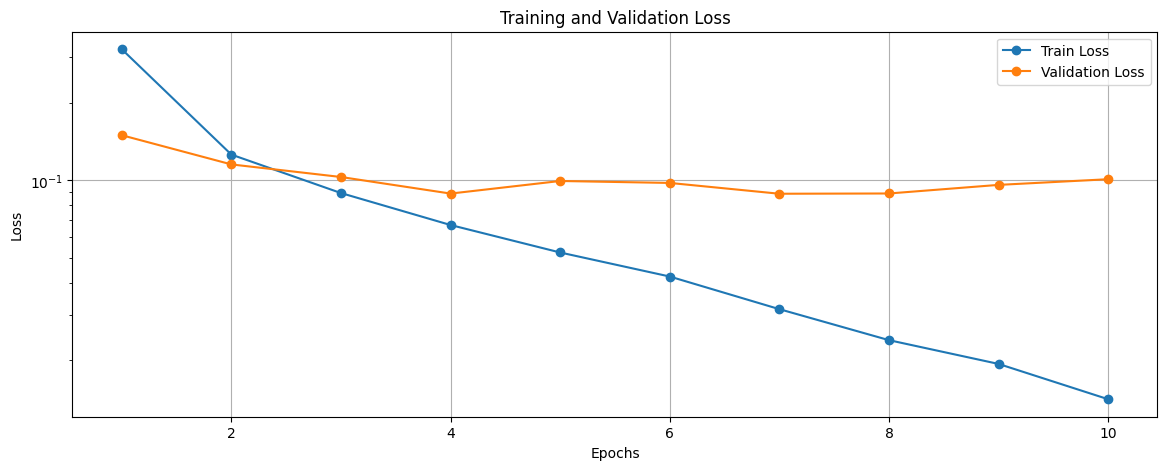

Epoch 11/200 - Train Loss: 0.0115, Validation Loss: 0.1124
Epoch 12/200 - Train Loss: 0.0115, Validation Loss: 0.1276
Epoch 13/200 - Train Loss: 0.0092, Validation Loss: 0.1161
Epoch 14/200 - Train Loss: 0.0057, Validation Loss: 0.1344
Epoch 15/200 - Train Loss: 0.0078, Validation Loss: 0.1459
Epoch 16/200 - Train Loss: 0.0059, Validation Loss: 0.1423
Epoch 17/200 - Train Loss: 0.0056, Validation Loss: 0.1374
Epoch 18/200 - Train Loss: 0.0057, Validation Loss: 0.1811
Epoch 19/200 - Train Loss: 0.0074, Validation Loss: 0.1420
Epoch 20/200 - Train Loss: 0.0039, Validation Loss: 0.1454


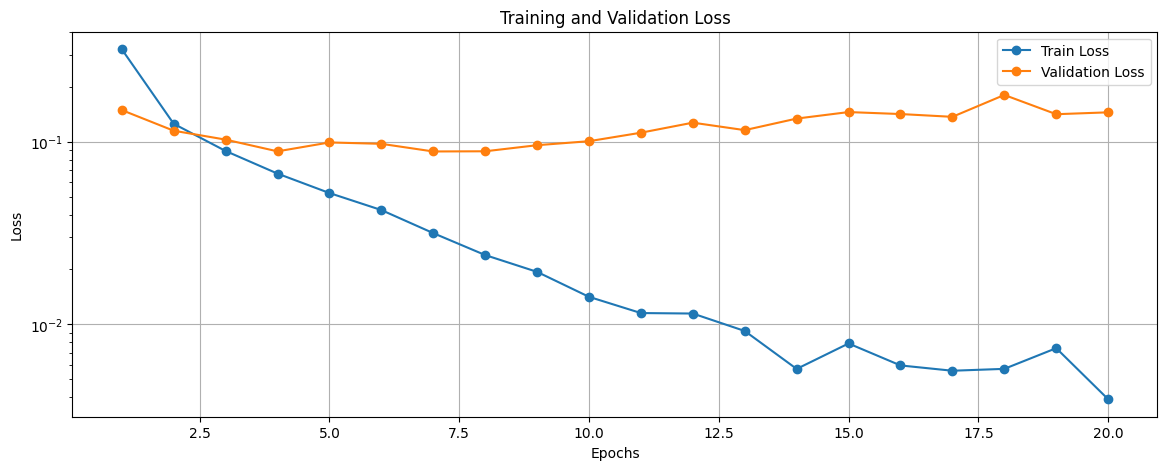

Epoch 21/200 - Train Loss: 0.0048, Validation Loss: 0.1388
Epoch 22/200 - Train Loss: 0.0034, Validation Loss: 0.1387
Epoch 23/200 - Train Loss: 0.0036, Validation Loss: 0.1882
Epoch 24/200 - Train Loss: 0.0044, Validation Loss: 0.1666
Epoch 25/200 - Train Loss: 0.0063, Validation Loss: 0.1471
Epoch 26/200 - Train Loss: 0.0021, Validation Loss: 0.1496
Epoch 27/200 - Train Loss: 0.0022, Validation Loss: 0.1659
Early stopping triggered after 20 epochs with no improvement.


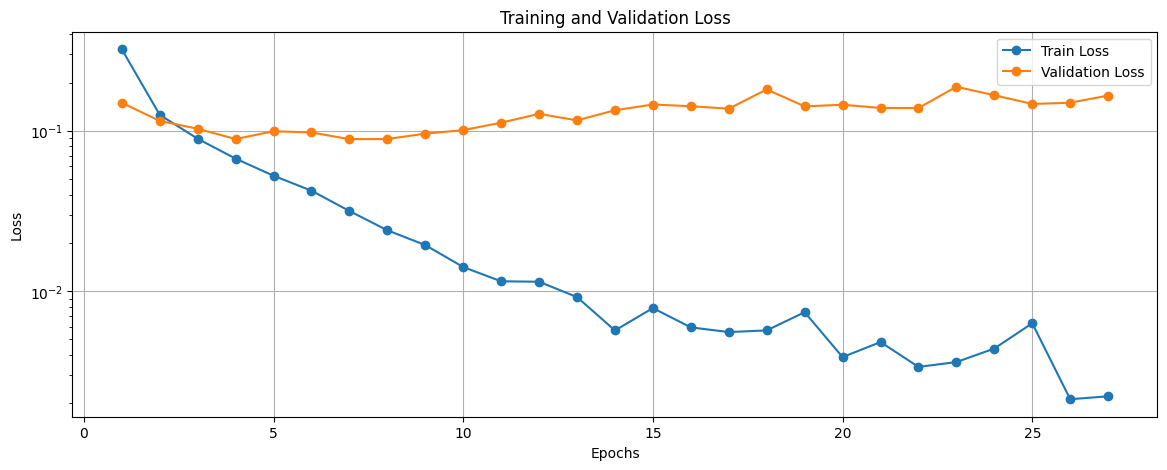

In [588]:
best_model, loss_validation = training_pipeline(epochs=epochs, model=model, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, patience=patience)